In [1]:
import os
import sys
import yaml
import json
import torch
import resampy
import librosa
import numpy as np
import pandas as pd
from tqdm import tqdm
import soundfile as sf
from pathlib import Path
from pprint import pprint
import matplotlib.pyplot as plt
import scipy.io.wavfile as wavfile
from collections import defaultdict
pipeline_root = Path().resolve().parents[0]
print(pipeline_root)
sys.path.append(str(pipeline_root)) # adding pipeline root to sys.path

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-r2e3_mui because the default path (/home/iiakovlev/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


/media/ssdraid0cgpu01/home/iiakovlev/new-pipeline/audio-pipelines-pytorch


In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
data_setup = yaml.safe_load((pipeline_root / 'data.yml').read_text())
ASVSPOOF2017 = data_setup['asv17_root']

In [4]:
from torch.utils.data import DataLoader
from models.utils import load_weights_from_pl_pipeline
from models.model_builders import AudioClassificationModel
from datautils.dataset import Dataset, simple_collate_func, DummyAugmentor

In [5]:
model_dir = pipeline_root/"checkpoints/device_detector/lrpd_aparts_lrpd_office"

In [6]:
model_config = json.loads((model_dir/"model_config.json").read_text())
embedding_model = AudioClassificationModel(**model_config)
embedding_model.cls_head.return_embeddings = True
embedding_model = embedding_model.eval()
weights_path = str(model_dir/"model.ckpt")
_ = load_weights_from_pl_pipeline(embedding_model,str(weights_path),remove_unessacary=False,strict=False)

unexpected_keys : []
missing_keys : []


In [7]:
def parse_asv_spoof_folder(asv_spoof_root : str, part : str = "dev"):
    asv_spoof_root = Path(asv_spoof_root).resolve()
    wavs = [(wavp,wavp.name) for wavp in (asv_spoof_root/f"ASVspoof2017_V2_{part}").glob("*.wav")]
    protocol = pd.read_csv(str(asv_spoof_root/"protocol_V2"/f"ASVspoof2017_V2_{part}.{'trn' if part == 'train' else 'trl'}.txt"),sep=" ", names=["file","label","spk_id","phrase_id","env_id","play_id","rec_id"])
    return wavs, protocol

In [8]:
from typing import List, Tuple
def simple_collate_func(batch):
    xs, ys = list(zip(*batch))
    xs = np.stack(xs)
    ys = np.stack(ys)
    xs = torch.from_numpy(xs)
    return xs,ys

def get_embeddings(model, data : List[Tuple[Path,str]],utt_len_sec=3.0):
    val_dataset = Dataset(
        data=data,
        size=None,
        augmentor=DummyAugmentor(),
        utt_len_sec=utt_len_sec,
        samplerate=16000,
        convert_to_ohe=False
    )

    val_dl = DataLoader(dataset=val_dataset,
        batch_size=128, shuffle=False, sampler=None,
        batch_sampler=None, num_workers=10, collate_fn=simple_collate_func,
        pin_memory=True, drop_last=False, timeout=0,
        worker_init_fn=None, multiprocessing_context=None
    )

    embeddings = []
    file_ids = []
    model = model.cuda()
    with torch.no_grad():
        for batch in tqdm(val_dl):
            inputs, rlps = batch
            inputs = inputs.cuda()
            embeds = model(inputs)[1]
            file_ids.extend(rlps)
            embeddings.append(embeds.cpu().numpy())
    embeddings = np.concatenate(embeddings)
    embeddings = [embeddings[i] for i in range(embeddings.shape[0])]
    return dict(zip(file_ids,embeddings))

In [9]:
files, protocol = parse_asv_spoof_folder(ASVSPOOF2017,"eval")
protocol = protocol.set_index('file')
dev_embeddings = get_embeddings(embedding_model,files)
protocol["embeddings"] = protocol.index.map(lambda file : dev_embeddings[file])

  0%|          | 0/104 [00:00<?, ?it/s]

created ds with : 13306


100%|██████████| 104/104 [00:09<00:00, 10.79it/s]


In [10]:
protocol

,label,spk_id,phrase_id,env_id,play_id,rec_id,embeddings
file,,,,,,,
E_1000001.wav,spoof,M0029,S03,E19,P22,R22,"[0.0, 2.3654947, 0.22006717, 0.0, 1.2695533, 0..."
E_1000002.wav,spoof,M0027,S10,E19,P22,R22,"[0.0, 0.93318415, 0.0, 0.0, 0.14867428, 0.0, 0..."
E_1000003.wav,spoof,M0025,S01,E14,P03,R04,"[0.24532902, 0.44620025, 0.0, 0.0, 0.5285332, ..."
E_1000004.wav,spoof,M0035,S10,E12,P16,R11,"[0.8975603, 0.0, 0.0, 0.0, 1.1843964, 0.0, 0.0..."
E_1000005.wav,spoof,M0025,S10,E18,P05,R03,"[0.7921837, 1.4373811, 0.0, 0.0, 0.0, 0.409764..."
...,...,...,...,...,...,...,...
E_1014215.wav,spoof,M0023,S03,E25,P13,R08,"[1.8689791, 2.8678315, 0.0, 0.0, 0.0, 0.416024..."
E_1014216.wav,spoof,M0032,S01,E08,P20,R14,"[1.3294642, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4995812..."
E_1014217.wav,genuine,M0021,S04,-,-,-,"[0.43003052, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.1..."


In [11]:
### Embeddings visualisation with t-SNE

In [12]:
from sklearn.manifold import TSNE
file_ids = list(dev_embeddings.keys())
embeddings = list(dev_embeddings.values())
embeddings_tsne = TSNE(n_components=2, random_state=23).fit_transform(embeddings)

In [13]:
embeddings_tsne_dict = dict(zip(file_ids,embeddings_tsne))
protocol["tsne_embeddings"] = protocol.index.map(lambda file : embeddings_tsne_dict[file])

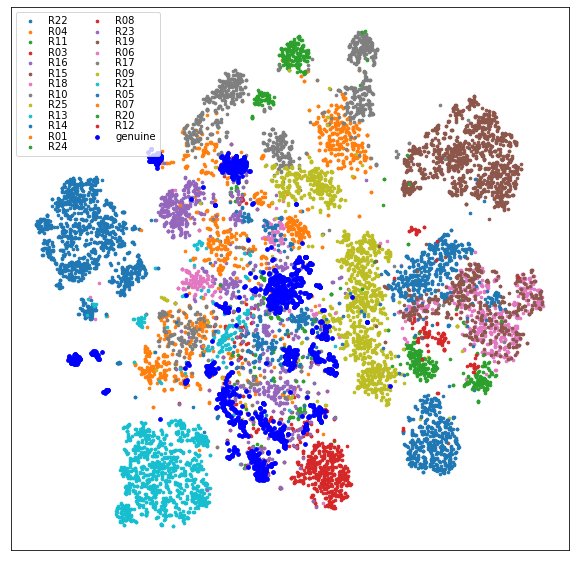

In [14]:
# embeddings_tsne
f, ax = plt.subplots(1,1,figsize=(10,10))
split_col = "rec_id"
for split_val in protocol[split_col].unique():
    if split_val == "-":
        continue
    tsne_embeddings_subset = protocol[protocol[split_col]==split_val]["tsne_embeddings"]
    tsne_embeddings_subset = np.array([v for v in tsne_embeddings_subset.values])
    ax.scatter(tsne_embeddings_subset[:, 0], tsne_embeddings_subset[:, 1], s=7, label=f"{split_val}")
    
tsne_embeddings_subset = protocol[protocol["label"]=="genuine"]["tsne_embeddings"]
tsne_embeddings_subset = np.array([v for v in tsne_embeddings_subset.values])
ax.scatter(tsne_embeddings_subset[:, 0], tsne_embeddings_subset[:, 1], c="b", s=14, label="genuine")
# ax.set_title("Di")
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.legend(ncol=2,labelspacing=0.05)